In [2]:
from matplotlib import pyplot as plt
import platform, os, sys, pprint, h5py, emoji
import numpy as np
from glob import glob
from tabulate import tabulate
from pprint import pprint
from importlib import reload
from scipy.optimize import minimize

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis
from TrapAnalysis import artificial_anneal as anneal

%matplotlib inline
%config InlineBackend.figure_format='retina'

Could not import BEM module. Please do so manually.


In [3]:
box_length=20E-6
inserted_res_length = 80

xeval = np.linspace(-4.0, box_length*1E6, 1000)
yeval = anneal.construct_symmetric_y(-4.0, 201)

dx = np.diff(xeval)[0]*1E-6
dy = np.diff(yeval)[0]*1E-6

master_path = r"/Users/gkoolstra/Desktop/Single electron loading/Potentials/M018V6/V6.2"
#r"/Volumes/slab/Gerwin/Electron on helium/Maxwell/M018 Yggdrasil/M018V4"

x_eval, y_eval, output = anneal.load_data(master_path, xeval=xeval, yeval=yeval, mirror_y=True,
                                          extend_resonator=False, insert_resonator=True, do_plot=False,
                                          inserted_res_length=inserted_res_length, smoothen_xy=(0.25E-6, dy))

Resonator data was inserted from x = 9.38 um to x = 89.38 um


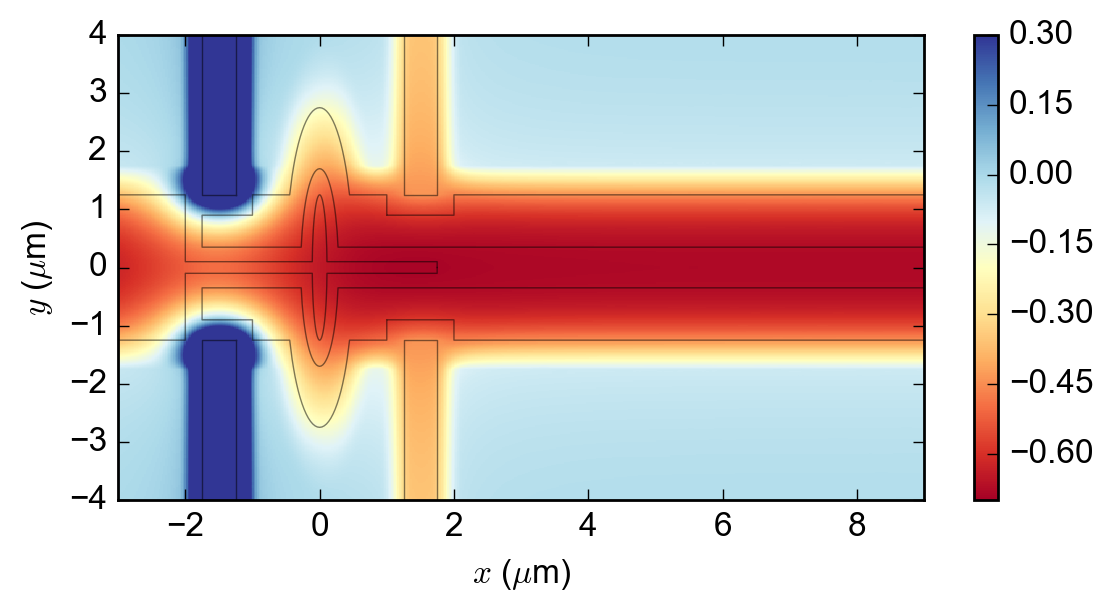

In [4]:
coefficients = [1.00, 0.98, 0.40, -1.50]

for i, c in enumerate(coefficients):
    if i == 0:
        potential_data = output[i]['V'] * c
    else: 
        potential_data += output[i]['V'] * c 

PP = anneal.PostProcess(save_path=None)

# Plot the resonator and trap electron configuration
fig2 = plt.figure(figsize=(6.5, 3))
common.configure_axes(12)
plt.pcolormesh(x_eval[0,:] * 1E6, y_eval[:,0] * 1E6, -potential_data.T, cmap=plt.cm.RdYlBu, vmax=+0.30, vmin=-0.70)
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")
#plt.xlim(np.min(x_eval)*1E6, 10)
#plt.ylim(np.min(y_eval)*1E6, np.max(y_eval)*1E6)
PP.draw_from_dxf(r"/Users/gkoolstra/Desktop/Single electron loading/Potentials/M018V6/V6.2/all_electrodes.dxf", 
                 color='black', alpha=0.5, lw=0.5)

plt.xlim(-3,9)
plt.ylim(-4,4)

plt.colorbar()
plt.show()

#common.save_figure(fig2, save_path=r"/Users/gkoolstra/Google Drive/grad school/schuster lab/Presentations/March Meeting 2017")

In [5]:
CMS = anneal.TrapAreaSolver(x_eval[0,:], y_eval[:,0], -potential_data,
                            spline_order_x=3, spline_order_y=3, smoothing=0.01,
                            include_screening=True, screening_length=2*0.75E-6)

In [6]:
X_eval, Y_eval = np.meshgrid(x_eval[0,:], y_eval[:,0])

# Minimization using simple gradient descent

You have to be careful with the stepsize. Using too big of a step size in the beginning will displace the electrons outside the simulation domain and if the step size is too small it will take forever. Moreover, the step size in the beginning of the minimization may be chosen well, but that is not to say that this is the appropriate step size when approaching a zero gradient. In general the strategy is the increase the step size (multiplier) slightly as the gradient is smaller (in order to speed up the simulation). In principle, a constant multiplier will work fine with a disadvantage of taking more iterations before the minimizer terminates. With a power law with exponent 0.2 we found decent results.

In [101]:
def get_step_size(metric):
    return 1E-12 * (5E4/np.abs(metric))**(0.2)

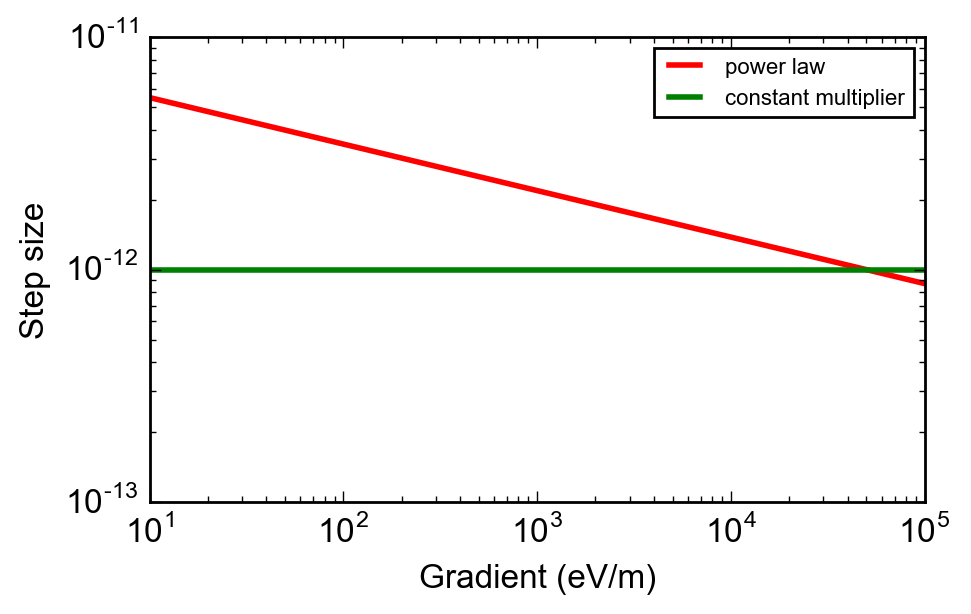

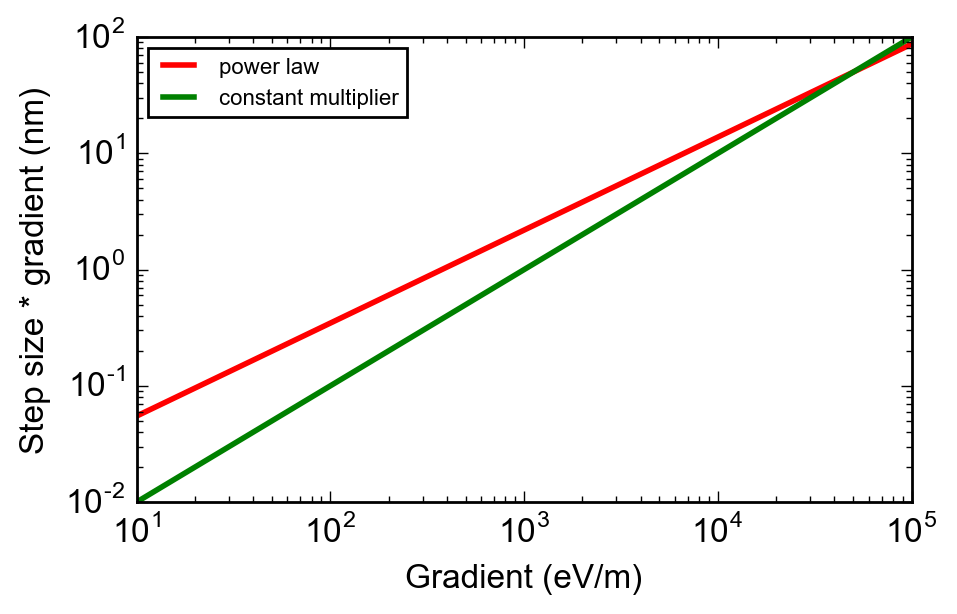

In [102]:
metric = np.logspace(1, 5, 1E3)
steps = get_step_size(metric)

plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.plot(metric, steps, '-r', lw=2, label="power law")
plt.plot(metric, np.ones(len(metric)) * 1E-12, '-g', lw=2, label="constant multiplier")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Gradient (eV/m)")
plt.ylabel("Step size")
plt.legend(loc=0, prop={'size' : 8})

plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.plot(metric, steps * metric * 1E9, '-r', lw=2, label="power law")
plt.plot(metric, 1E-12 * metric * 1E9, '-g', lw=2, label="constant multiplier")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Gradient (eV/m)")
plt.ylabel("Step size * gradient (nm)")
plt.legend(loc=0, prop={'size' : 8})

In [104]:
N_electrons = 160
N_rows = N_electrons
row_spacing = 0.05E-6
N_cols = 1
col_spacing = 0.10E-6

xk = anneal.get_rectangular_initial_condition(N_electrons, N_rows=N_rows, N_cols=N_cols,
                                                                      x0=(inserted_res_length*1E-6 + box_length)/2., 
                                                                      y0=0.0E-6, dx=0.30E-6)
grad_tol = np.amax(CMS.grad_total(xk))
step_size = 1E-12
k = 0

while grad_tol > 1E1:
    current_gradient = CMS.grad_total(xk)
    grad_tol = np.amax(current_gradient)
    step_size = get_step_size(grad_tol)
    
    if k == 0: 
        print(np.amax(current_gradient))
        print(np.amax(current_gradient * step_size))
    
    xk -= current_gradient * get_step_size(current_gradient)
    k += 1
    
    if not(k%2000):  
        print(grad_tol)

print("Simulation terminated successfully!")

23282.7475713
2.71282253597e-08
1230.39606609
848.57309081
639.704705706
632.125169543
2433.66843312
1446.06503828
1132.50061657
388.164461483
178.941693097
137.604275627
94.3995136791
68.5872350435
52.9397935393
43.3699216506
34.129570276
27.6302197167
51.823890319
21.0408501123
18.6136981056
16.1133478477
13.9100932931
11.996866419
10.3342788219


The _disadvantage_ of this method is that it takes a little longer for the simulation to converge. In fact, if you don't choose your step size carefully, the simulation may not converge at all. The limited speed of the simulation becomes especially apparent at low gradients, where the electron displacement is quite small. It may also be tricky to adjust the step size for only low gradients while leaving the behavior for large gradients untouched (i.e. this may lead to convergence issues).
The _advantage_ is that this is really physical, since each iteration really represents a step in time. Furthermore, you have the ability to add temperature noise to each time step, such that you can really simulate annealing. 

# Minimization using `scipy` code

In [37]:
# Solve for the electron positions in the trap area!
ConvMon = anneal.ConvergenceMonitor(Uopt=CMS.Vtotal, grad_Uopt=CMS.grad_total, N=1,
                                    Uext=CMS.V, xext=np.arange(-2E-6, 6E-6, dx), yext=y_eval[:,0], verbose=True, eps=1E-10,
                                    figsize=(6.5, 3.0), clim=(-0.75, 0.30),
                                    save_path=r"/Users/gkoolstra/Desktop/Single electron loading/Anneal example")

ConvMon.figsize = (6.5, 3.0)
ConvMon.electrode_outline_filename = r"/Users/gkoolstra/Desktop/Single electron loading/Potentials/M018V6/V6.2/all_electrodes.dxf"

N_electrons = 160
N_rows = N_electrons
row_spacing = 0.10E-6
N_cols = 1
col_spacing = 0.10E-6

electron_initial_positions = anneal.get_rectangular_initial_condition(N_electrons, N_rows=N_rows, N_cols=N_cols,
                                                                      x0=(inserted_res_length*1E-6 + box_length)/2., 
                                                                      y0=0.0E-6, dx=0.20E-6)

trap_minimizer_options = {'jac': CMS.grad_total,
                          'options': {'disp': False, 'gtol': 1E2, 'eps': 1E-10},
                          'callback': ConvMon.monitor_convergence}

res = minimize(CMS.Vtotal, electron_initial_positions, method='L-BFGS-B', **trap_minimizer_options)

print(res['message'])

0	Uopt: -106.81212871 eV	Norm of gradient: 8.46e+03 eV/m
1	Uopt: -106.83427937 eV	Norm of gradient: 7.22e+03 eV/m
2	Uopt: -106.86321630 eV	Norm of gradient: 6.62e+03 eV/m
3	Uopt: -106.92920027 eV	Norm of gradient: 6.15e+03 eV/m
4	Uopt: -106.96051291 eV	Norm of gradient: 1.64e+04 eV/m
5	Uopt: -107.01639498 eV	Norm of gradient: 1.09e+05 eV/m
6	Uopt: -107.05358885 eV	Norm of gradient: 1.38e+05 eV/m
7	Uopt: -107.13058163 eV	Norm of gradient: 1.09e+05 eV/m
8	Uopt: -107.16335400 eV	Norm of gradient: 1.89e+05 eV/m
9	Uopt: -107.16876135 eV	Norm of gradient: 1.93e+05 eV/m
10	Uopt: -107.18005659 eV	Norm of gradient: 1.90e+05 eV/m
11	Uopt: -107.20998682 eV	Norm of gradient: 6.42e+04 eV/m
12	Uopt: -107.24312693 eV	Norm of gradient: 3.07e+04 eV/m
13	Uopt: -107.24844789 eV	Norm of gradient: 2.93e+04 eV/m
14	Uopt: -107.29567525 eV	Norm of gradient: 3.97e+04 eV/m
15	Uopt: -107.31133498 eV	Norm of gradient: 8.73e+04 eV/m
16	Uopt: -107.32095120 eV	Norm of gradient: 6.69e+04 eV/m
17	Uopt: -107.34407510 e

# Plot the result from any of the methods above

It will plot the result from the last code block run above

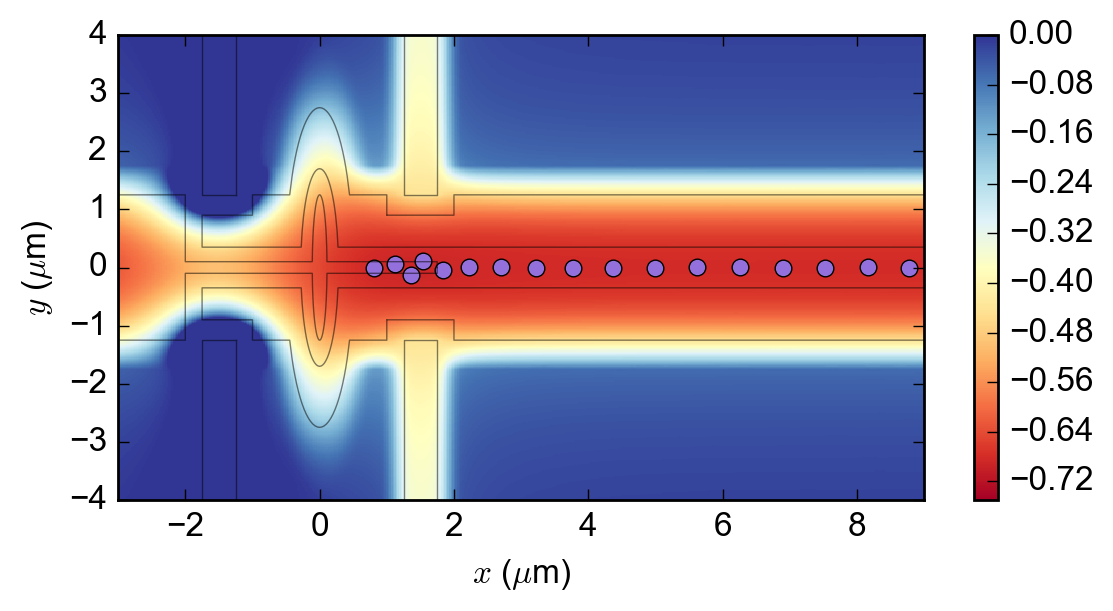

In [90]:
PP = anneal.PostProcess(save_path=None)

# Plot the resonator and trap electron configuration
fig2 = plt.figure(figsize=(6.5, 3))
common.configure_axes(12)
plt.pcolormesh(x_eval[0,:] * 1E6, y_eval[:,0] * 1E6, -potential_data.T, cmap=plt.cm.RdYlBu, vmax=0.0, vmin=-0.75)
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")
plt.plot(xk[::2]*1E6, xk[1::2]*1E6, 'o', color="mediumpurple")
#plt.plot(res['x'][::2] * 1E6, res['x'][1::2] * 1E6 , 'o', color="mediumpurple")
#plt.xlim(np.min(x_eval)*1E6, 10)
#plt.ylim(np.min(y_eval)*1E6, np.max(y_eval)*1E6)
PP.draw_from_dxf(r"/Users/gkoolstra/Desktop/Single electron loading/Potentials/M018V6/V6.2/all_electrodes.dxf", 
                 color='black', alpha=0.5, lw=0.5)

plt.xlim(-3,9)
plt.ylim(-4,4)

plt.colorbar()
plt.show()

#common.save_figure(fig2, save_path=r"/Users/gkoolstra/Google Drive/grad school/schuster lab/Presentations/March Meeting 2017")

# Plot and save all frames for a movie

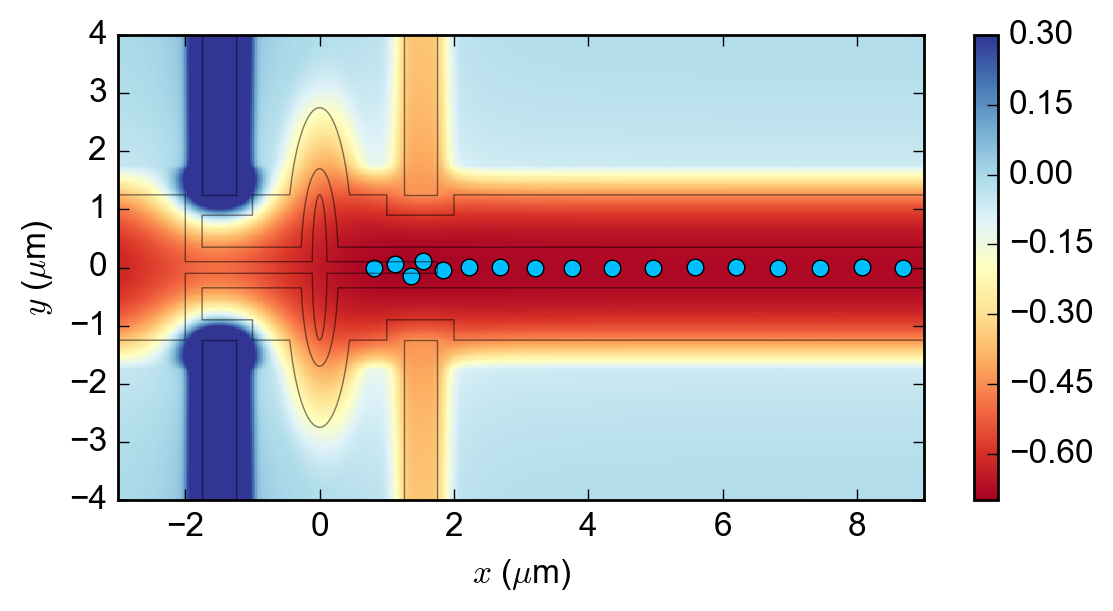

In [39]:
PP = anneal.PostProcess(save_path=None)

# Plot the resonator and trap electron configuration
fig2 = plt.figure(figsize=(6.5, 3))

ax = fig2.add_subplot(111)
plt.pcolormesh(x_eval[0,:] * 1E6, y_eval[:,0] * 1E6, -potential_data.T, cmap=plt.cm.RdYlBu, vmax=+0.30, vmin=-0.70)
line1, = plt.plot(ConvMon.curr_xk[0,::2] * 1E6, ConvMon.curr_xk[0,1::2] * 1E6, 'o', color='deepskyblue')

common.configure_axes(12)

plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")
#plt.plot(ConvMon.curr_xk[0,::2] * 1E6, ConvMon.curr_xk[0,1::2] * 1E6 , 'o', color='deepskyblue')
#plt.xlim(np.min(x_eval)*1E6, 10)
#plt.ylim(np.min(y_eval)*1E6, np.max(y_eval)*1E6)
PP.draw_from_dxf(r"/Users/gkoolstra/Desktop/Single electron loading/Potentials/M018V6/V6.2/all_electrodes.dxf", 
                 color='black', alpha=0.5, lw=0.5)

plt.xlim(-3,9)
plt.ylim(-4,4)

plt.colorbar()

for el in range(np.shape(ConvMon.curr_xk[1:,:])[0]):
    line1.set_ydata(ConvMon.curr_xk[el,1::2] * 1E6)
    line1.set_xdata(ConvMon.curr_xk[el,::2] * 1E6)
    fig2.canvas.draw()
    
    common.save_figure(fig2, save_path = r"/Users/gkoolstra/Desktop/Single electron loading/Data/Annealing Examples/M018V6.2 (80 um box and 160 electrons)")
#plt.close(fig2)